In [2]:
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter
import random

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k
# from tensorflow.keras.optimizers.legacy import Adam

from tensorflow.python.client import device_lib

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [4]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [5]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.1


In [6]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


In [7]:
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3278035657005117877
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5750390784
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3851265653423403563
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [9]:
tf.test.is_built_with_cuda()

True

In [10]:
seed_val = 43

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(seed_val)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(seed_val)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(seed_val)

## EDA Functions

In [11]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [12]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

## Research Assignment Reporting Functions

In [13]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 
    
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Load Data

In [14]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

## EDA

In [15]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


In [25]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[3]
 [4]
 [4]
 [0]
 [1]
 [7]
 [1]
 [2]
 [3]
 [8]]

This output the numeric label, need to convert to item description


In [26]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [27]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

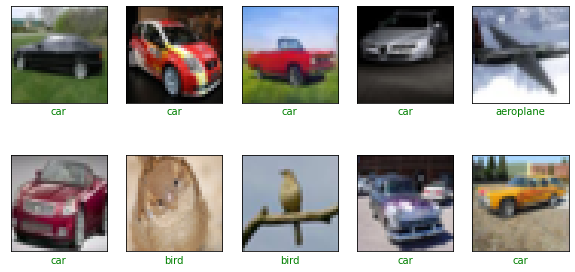

In [28]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

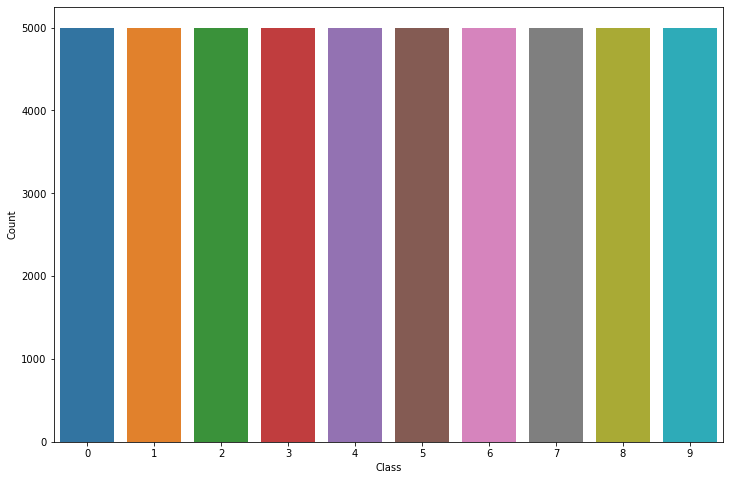

In [29]:
plt.figure(figsize = (12 ,8))
items = [{'Class': x, 'Count': y} for x, y in Counter(train_labels.ravel()).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

In [30]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

## Create Validation Data Set

In [31]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train
                                                     ,y_train
                                                     ,test_size=.1
                                                     ,random_state=seed_val
                                                     ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [32]:
print(x_train.shape, x_valid.shape, x_test.shape)

(40500, 32, 32, 3) (4500, 32, 32, 3) (10000, 32, 32, 3)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [33]:
x_train_norm = x_train/255
x_valid_norm = x_valid/255
x_test_norm = x_test/255

In [34]:
y_train_hot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_valid_hot = tf.keras.utils.to_categorical(y_valid, num_classes=10)
y_test_hot = tf.keras.utils.to_categorical(y_test, num_classes=10)


## Experiment 10 - TWEAK

- CNN with 3 layers/max pooling layers
- 2 Fully-Connected Hidden Layers (384, 768)
- Dropout(variable)
- L2 Regularization(variable)
- Batch Normalization

In [97]:
l2_rate = 0.001
# l2_rate = 0.01
# l2_rate = 0.1
#l2_rate = 0.0001

# dropout_rate = 0.2
# dropout_rate = 0.3
dropout_rate = 0.5

In [106]:
k.clear_session()
model_10 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(dropout_rate),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(dropout_rate),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(dropout_rate),
  Flatten(),
  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(l2_rate)),
  BatchNormalization(),
  Dropout(dropout_rate),
  Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(l2_rate)),
  BatchNormalization(),
  Dropout(dropout_rate),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [107]:
model_10.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)         0

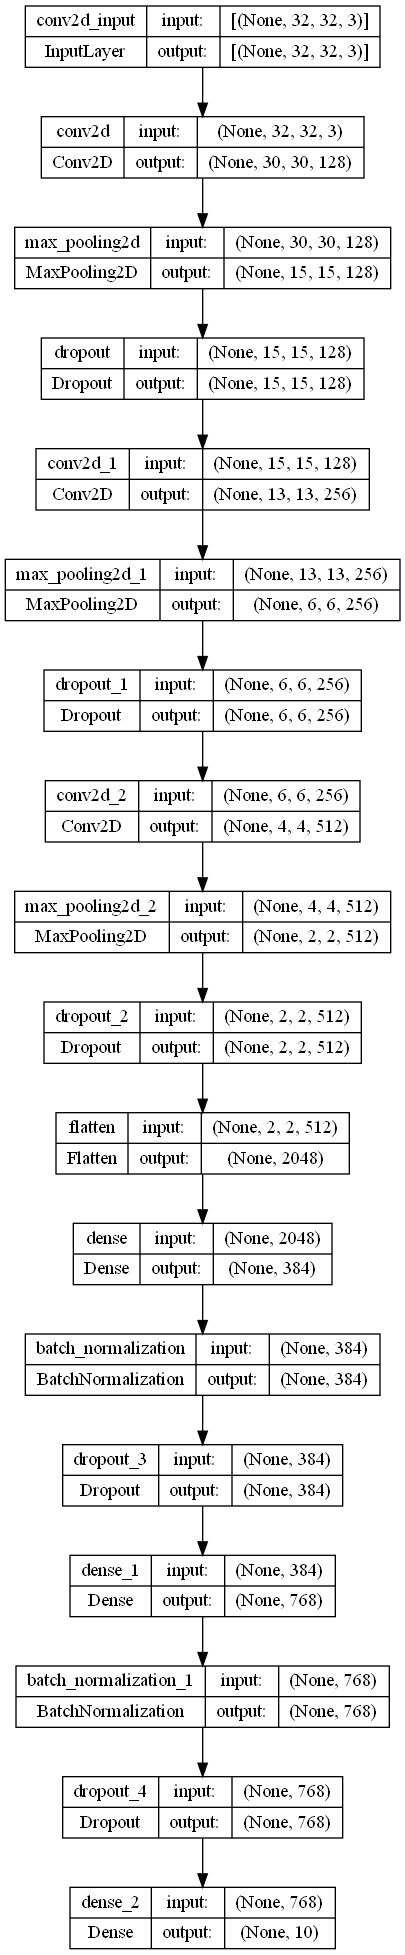

In [108]:
keras.utils.plot_model(model_10, "CIFAR10_EXP_10_TWEAK.png", show_shapes=True) 

In [109]:
model_10.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [110]:
history_10 = model_10.fit(x_train_norm
                    ,y_train
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_10_3CNN_2DNN_BN_TWEAK_L2001_DO05.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
                    ]                                                                                                           
                   )

Epoch 1/200
633/633 [==============================] - 11s 15ms/step - loss: 2.5657 - accuracy: 0.3565 - val_loss: 1.9471 - val_accuracy: 0.4784
Epoch 2/200
633/633 [==============================] - 9s 15ms/step - loss: 1.7390 - accuracy: 0.5265 - val_loss: 1.6003 - val_accuracy: 0.5558
Epoch 3/200
633/633 [==============================] - 9s 13ms/step - loss: 1.4011 - accuracy: 0.6048 - val_loss: 1.1947 - val_accuracy: 0.6587
Epoch 4/200
633/633 [==============================] - 9s 14ms/step - loss: 1.2272 - accuracy: 0.6486 - val_loss: 1.1426 - val_accuracy: 0.6669
Epoch 5/200
633/633 [==============================] - 8s 13ms/step - loss: 1.1226 - accuracy: 0.6780 - val_loss: 1.1593 - val_accuracy: 0.6767
Epoch 6/200
633/633 [==============================] - 8s 13ms/step - loss: 1.0519 - accuracy: 0.6997 - val_loss: 1.0893 - val_accuracy: 0.6809
Epoch 7/200
633/633 [==============================] - 8s 13ms/step - loss: 0.9940 - accuracy: 0.7209 - val_loss: 0.9332 - val_accuracy

In [61]:
# model_10 = tf.keras.models.load_model("A2_Exp_10_3CNN_2DNN_BN_TWEAK_L201_DO03.h5") # l2_rate = 0.01, dropout_rate = 0.3
# print(f"Test acc: {model_10.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.7930 - accuracy: 0.8054
Test acc: 0.805


In [89]:
# model_10 = tf.keras.models.load_model("A2_Exp_10_3CNN_2DNN_BN_TWEAK_L201_DO03_2nd.h5") # l2_rate = 0.01, dropout_rate = 0.3
# print(f"Test acc: {model_10.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.8074 - accuracy: 0.8021
Test acc: 0.802


In [41]:
# model_10 = tf.keras.models.load_model("A2_Exp_10_3CNN_2DNN_BN_TWEAK_L20001_DO03.h5") # l2_rate = 0.0001, dropout_rate = 0.3
# print(f"Test acc: {model_10.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.7911 - accuracy: 0.8036
Test acc: 0.804


In [50]:
# model_10 = tf.keras.models.load_model("A2_Exp_10_3CNN_2DNN_BN_TWEAK_L21_DO03.h5") # l2_rate = 0.1, dropout_rate = 0.3
# print(f"Test acc: {model_10.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.9535 - accuracy: 0.7826
Test acc: 0.783


In [60]:
# model_10 = tf.keras.models.load_model("A2_Exp_10_3CNN_2DNN_BN_TWEAK_L201_DO02.h5") # l2_rate = 0.01, dropout_rate = 0.2
# print(f"Test acc: {model_10.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.8262 - accuracy: 0.7788
Test acc: 0.779


In [73]:
# model_10 = tf.keras.models.load_model("A2_Exp_10_3CNN_2DNN_BN_TWEAK_L201_DO05.h5") # l2_rate = 0.01, dropout_rate = 0.5
# print(f"Test acc: {model_10.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 1.0087 - accuracy: 0.8031
Test acc: 0.803


In [81]:
# model_10 = tf.keras.models.load_model("A2_Exp_10_3CNN_2DNN_BN_TWEAK_L2001_DO03.h5") # l2_rate = 0.001, dropout_rate = 0.3
# print(f"Test acc: {model_10.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.7363 - accuracy: 0.8100
Test acc: 0.810


In [104]:
# model_10 = tf.keras.models.load_model("A2_Exp_10_3CNN_2DNN_BN_TWEAK_L2001_DO02.h5") # l2_rate = 0.001, dropout_rate = 0.2
# print(f"Test acc: {model_10.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.8425 - accuracy: 0.7882
Test acc: 0.788


In [111]:
model_10 = tf.keras.models.load_model("A2_Exp_10_3CNN_2DNN_BN_TWEAK_L2001_DO05.h5") # l2_rate = 0.001, dropout_rate = 0.5
print(f"Test acc: {model_10.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.8510 - accuracy: 0.7896
Test acc: 0.790


In [51]:
pred10 = model_10.predict(x_test_norm)
print('shape of preds: ', pred10.shape)

313/313 [==============================] - 1s 3ms/step
shape of preds:  (10000, 10)


In [52]:
history_10_dict = history_10.history
history_10_df=pd.DataFrame(history_10_dict)
history_10_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
51,0.995,0.768,1.004,0.764
52,0.991,0.771,0.980,0.769
53,0.996,0.771,1.014,0.763
54,0.997,0.772,0.974,0.772
55,0.977,0.775,0.965,0.775


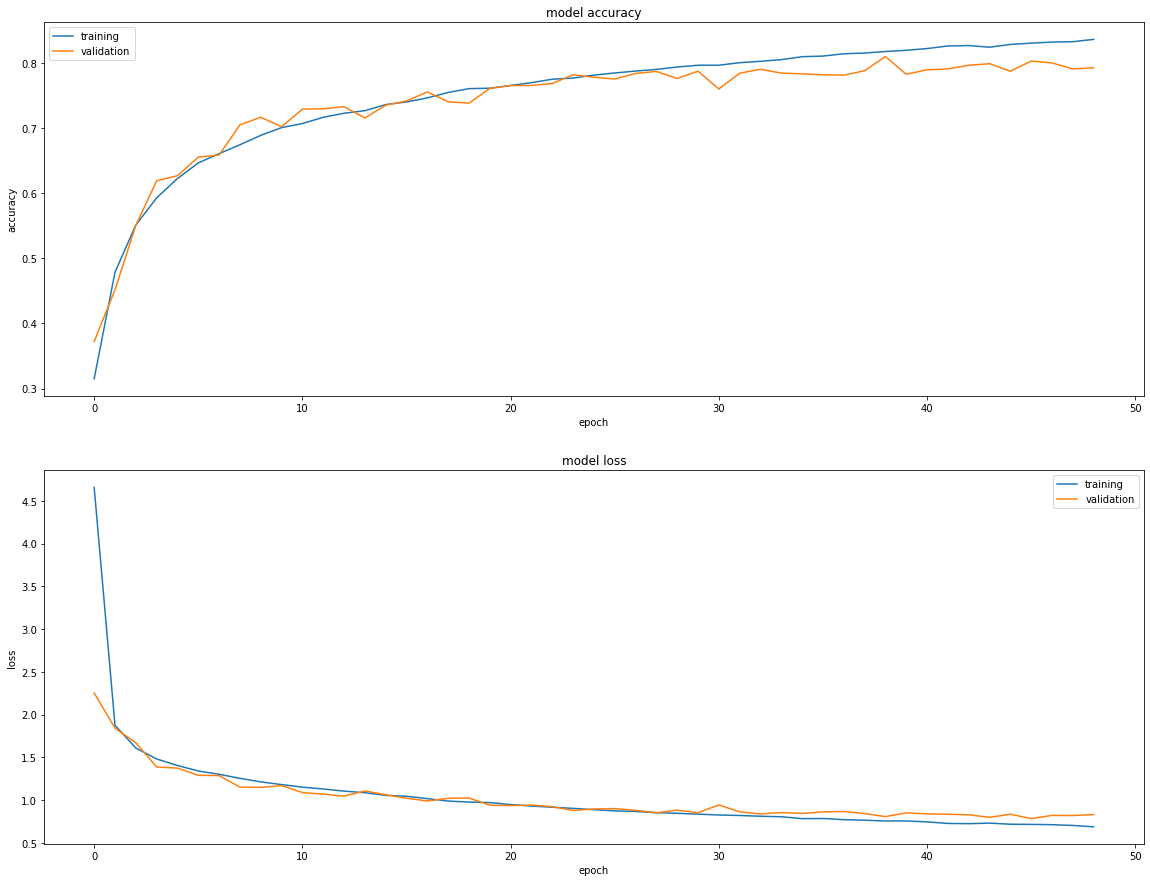

In [64]:
# plt.subplots(figsize=(16,12)) # l2_rate = 0.01, dropout_rate = 0.3
# plt.tight_layout()
# display_training_curves(history_10.history['accuracy'], history_10.history['val_accuracy'], 'accuracy', 211)
# display_training_curves(history_10.history['loss'], history_10.history['val_loss'], 'loss', 212)

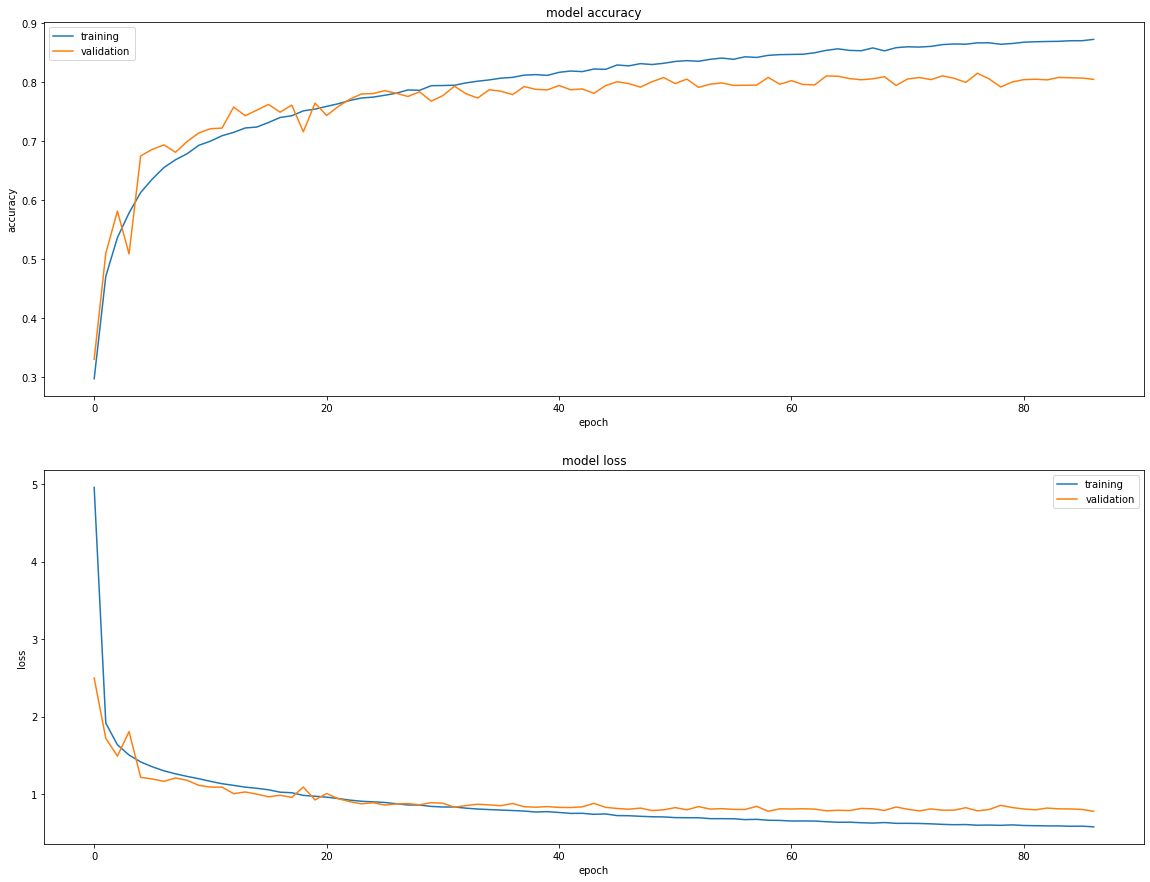

In [90]:
# plt.subplots(figsize=(16,12)) # l2_rate = 0.01, dropout_rate = 0.3 - second time
# plt.tight_layout()
# display_training_curves(history_10.history['accuracy'], history_10.history['val_accuracy'], 'accuracy', 211)
# display_training_curves(history_10.history['loss'], history_10.history['val_loss'], 'loss', 212)

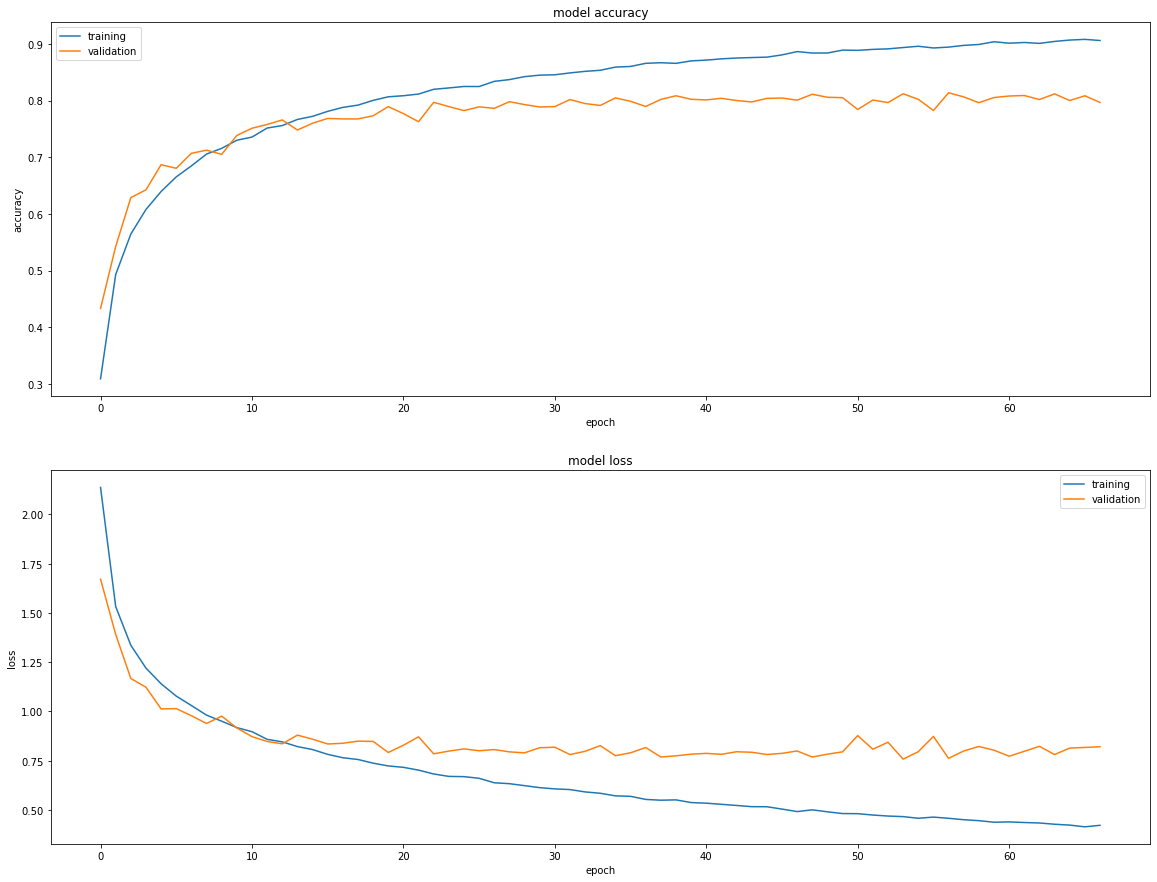

In [42]:
# plt.subplots(figsize=(16,12)) # l2_rate = 0.0001, dropout_rate = 0.3
# plt.tight_layout()
# display_training_curves(history_10.history['accuracy'], history_10.history['val_accuracy'], 'accuracy', 211)
# display_training_curves(history_10.history['loss'], history_10.history['val_loss'], 'loss', 212)

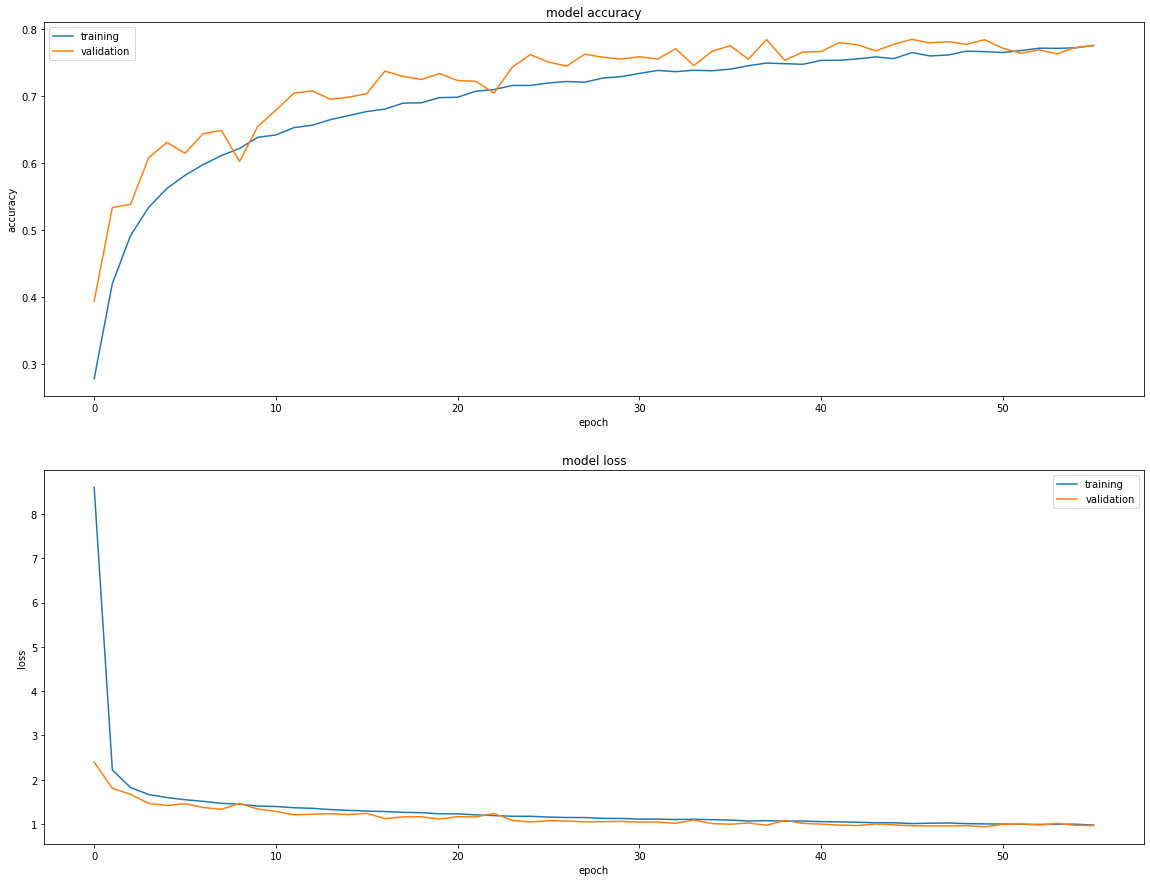

In [53]:
# plt.subplots(figsize=(16,12)) # l2_rate = 0.1, dropout_rate = 0.3
# plt.tight_layout()
# display_training_curves(history_10.history['accuracy'], history_10.history['val_accuracy'], 'accuracy', 211)
# display_training_curves(history_10.history['loss'], history_10.history['val_loss'], 'loss', 212)

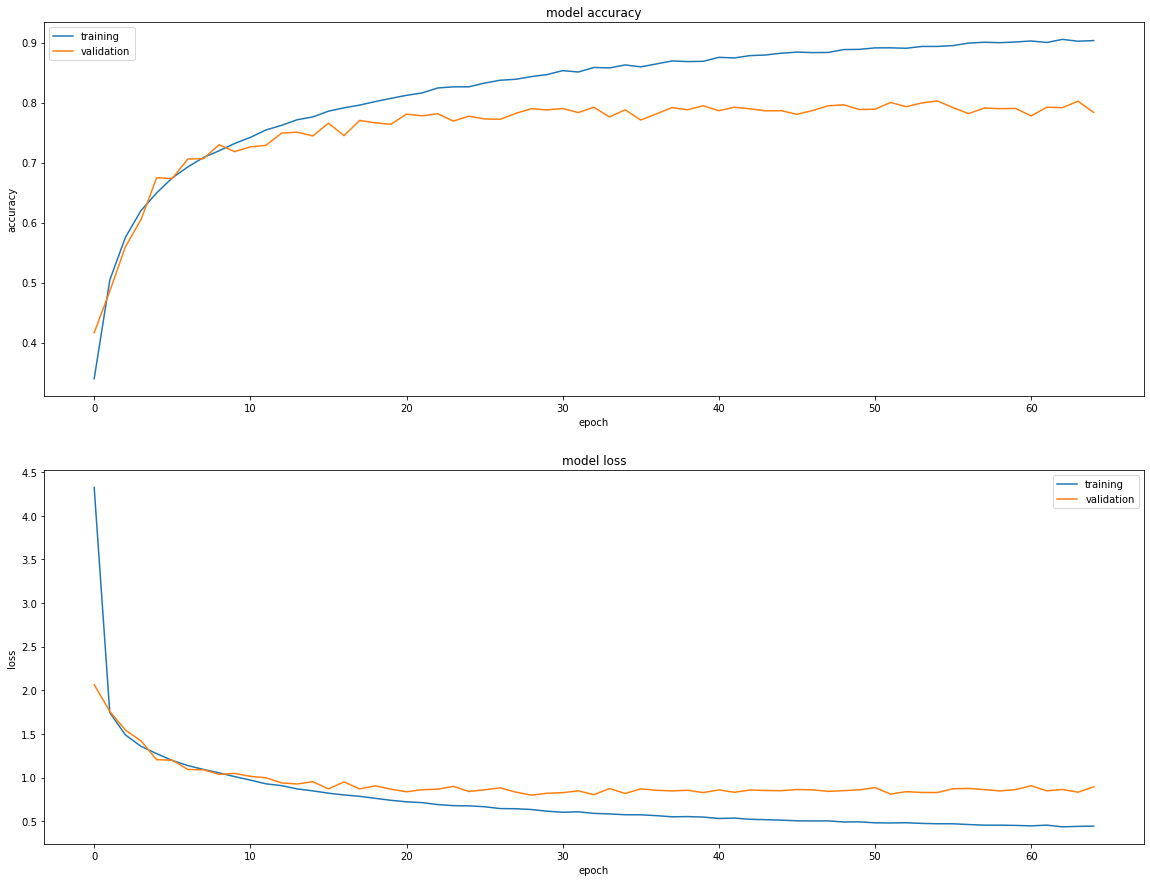

In [61]:
# plt.subplots(figsize=(16,12)) # l2_rate = 0.01, dropout_rate = 0.2
# plt.tight_layout()
# display_training_curves(history_10.history['accuracy'], history_10.history['val_accuracy'], 'accuracy', 211)
# display_training_curves(history_10.history['loss'], history_10.history['val_loss'], 'loss', 212)

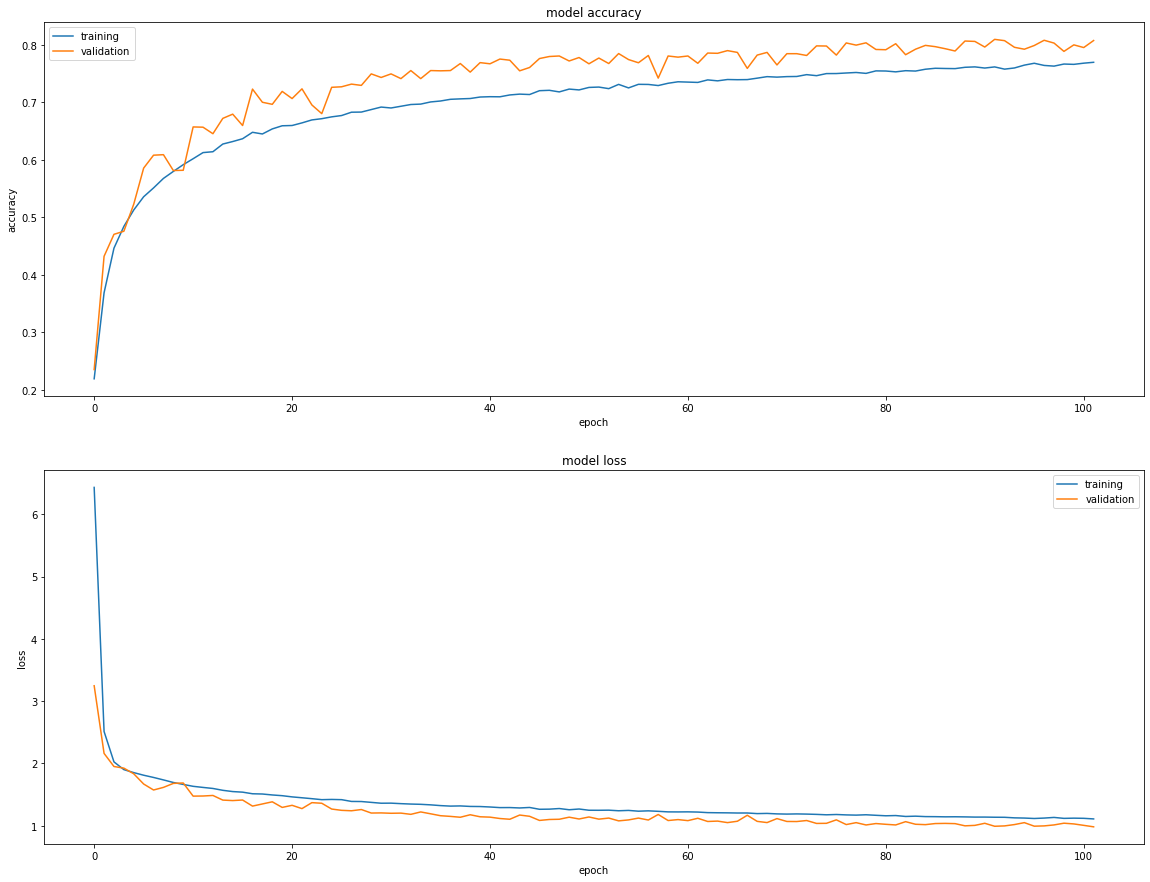

In [74]:
# plt.subplots(figsize=(16,12)) # l2_rate = 0.01, dropout_rate = 0.5
# plt.tight_layout()
# display_training_curves(history_10.history['accuracy'], history_10.history['val_accuracy'], 'accuracy', 211)
# display_training_curves(history_10.history['loss'], history_10.history['val_loss'], 'loss', 212)

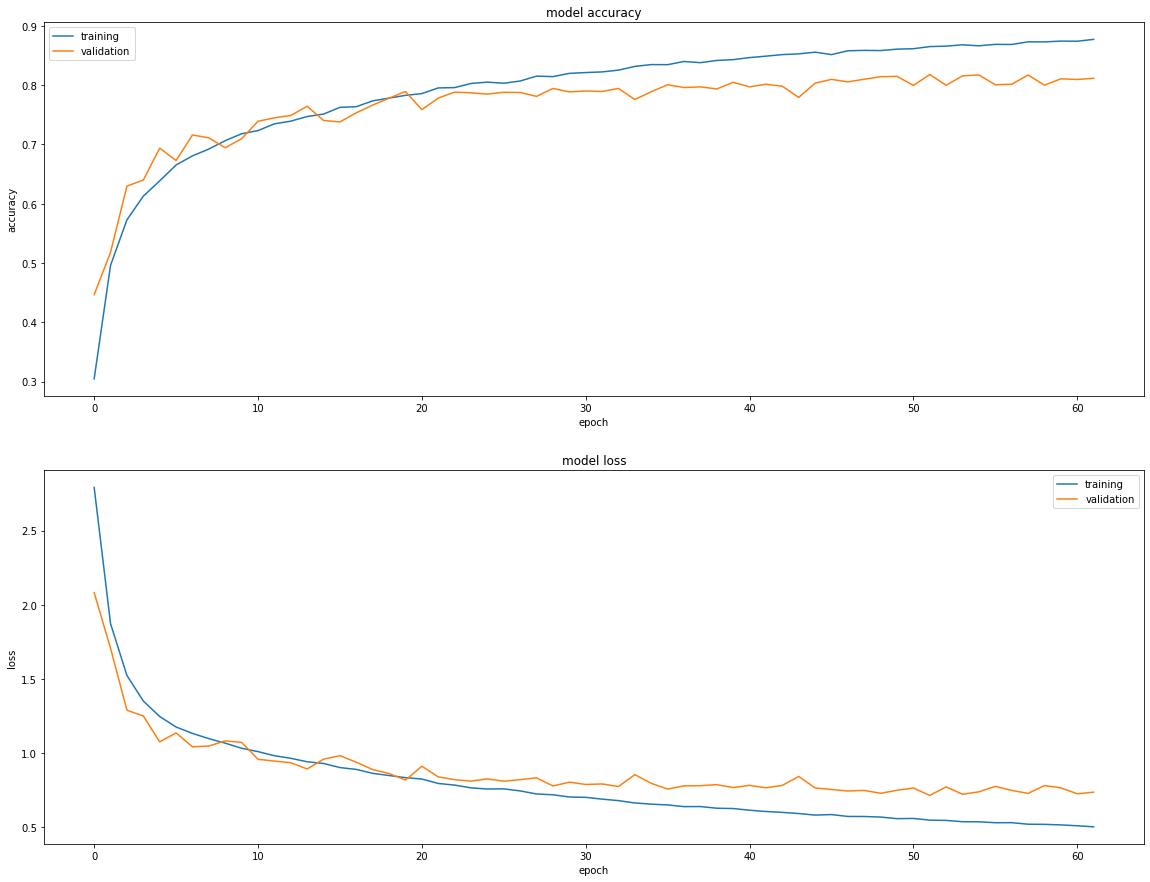

In [82]:
# plt.subplots(figsize=(16,12)) # l2_rate = 0.001, dropout_rate = 0.3
# plt.tight_layout()
# display_training_curves(history_10.history['accuracy'], history_10.history['val_accuracy'], 'accuracy', 211)
# display_training_curves(history_10.history['loss'], history_10.history['val_loss'], 'loss', 212)

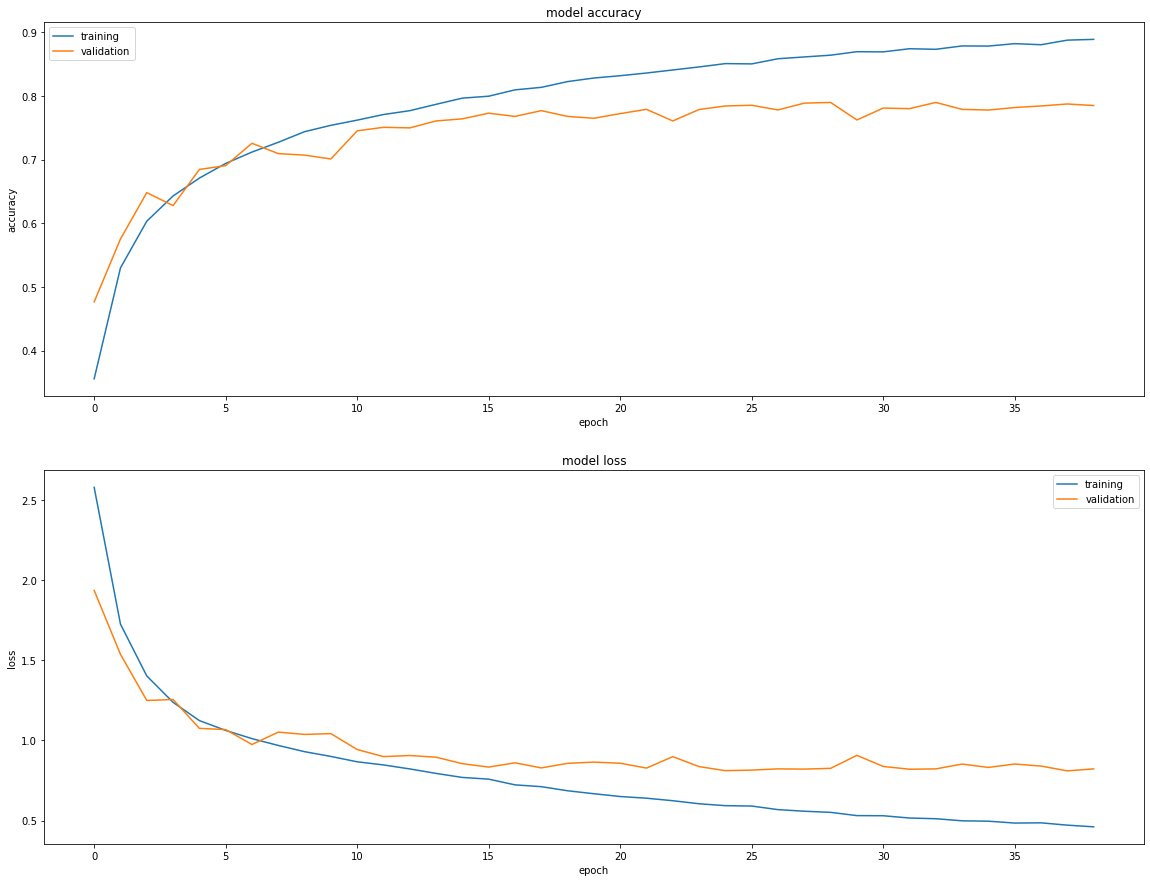

In [105]:
# plt.subplots(figsize=(16,12)) # l2_rate = 0.001, dropout_rate = 0.2
# plt.tight_layout()
# display_training_curves(history_10.history['accuracy'], history_10.history['val_accuracy'], 'accuracy', 211)
# display_training_curves(history_10.history['loss'], history_10.history['val_loss'], 'loss', 212)

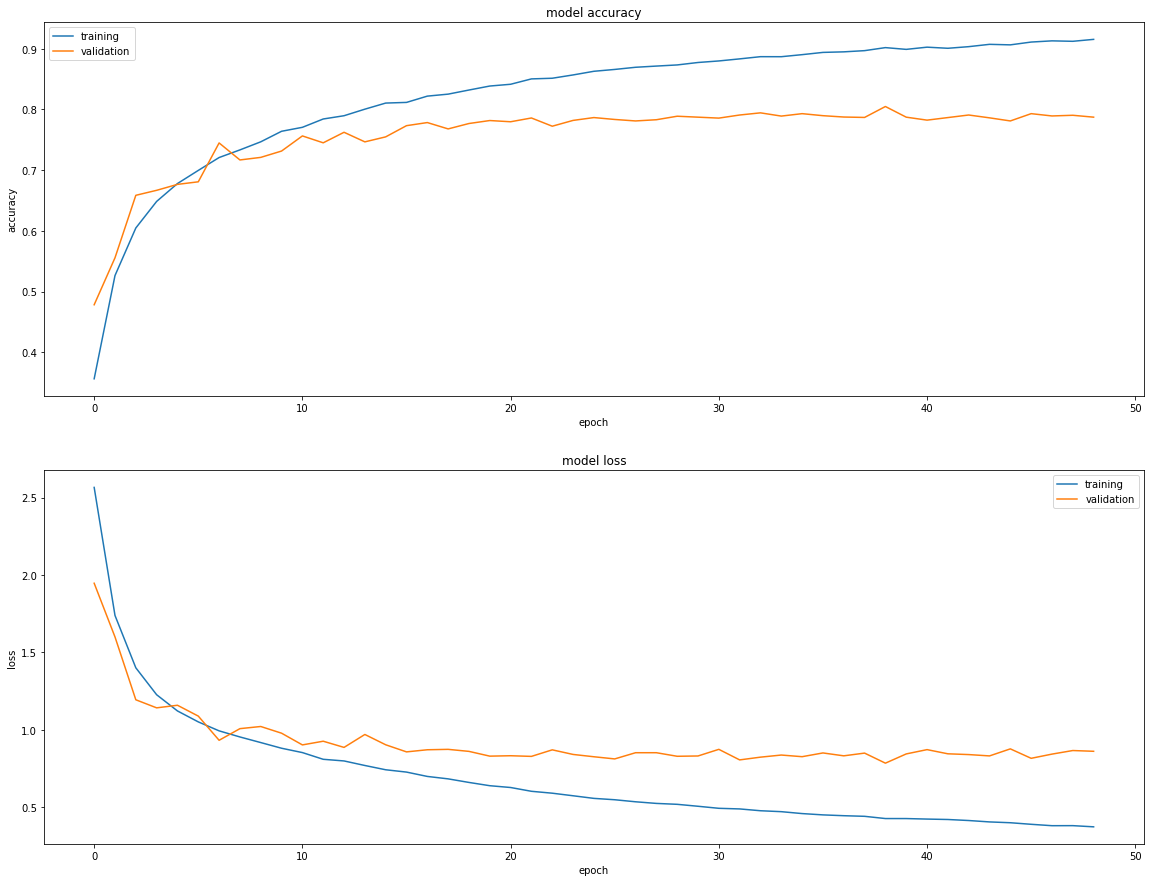

In [112]:
plt.subplots(figsize=(16,12)) # l2_rate = 0.001, dropout_rate = 0.5
plt.tight_layout()
display_training_curves(history_10.history['accuracy'], history_10.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_10.history['loss'], history_10.history['val_loss'], 'loss', 212)

In [65]:
pred10_cm=np.argmax(pred10, axis=1)
print_validation_report(y_test, pred10_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1000
           1       0.93      0.89      0.91      1000
           2       0.71      0.74      0.73      1000
           3       0.64      0.64      0.64      1000
           4       0.75      0.80      0.78      1000
           5       0.79      0.67      0.72      1000
           6       0.83      0.88      0.85      1000
           7       0.87      0.84      0.85      1000
           8       0.92      0.85      0.88      1000
           9       0.84      0.89      0.87      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

Accuracy Score: 0.8054
Root Mean Square Error: 1.8258148865643526


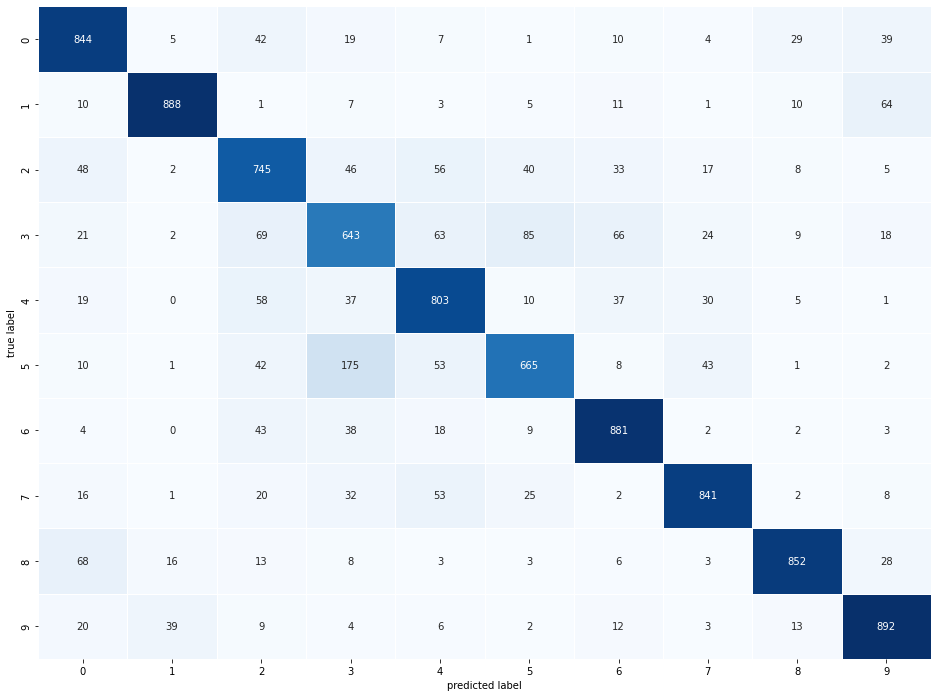

In [66]:
plot_confusion_matrix(y_test,pred10_cm)

In [67]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred10[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.46%,0.04%,0.40%,90.02%,0.37%,7.82%,0.60%,0.19%,0.09%,0.02%
1,0.54%,24.04%,0.04%,0.13%,0.02%,0.07%,0.19%,0.01%,74.70%,0.26%
2,1.12%,2.17%,0.33%,0.46%,0.13%,0.31%,0.33%,0.13%,92.72%,2.29%
3,97.53%,0.29%,0.85%,0.17%,0.06%,0.05%,0.02%,0.02%,0.31%,0.70%
4,0.00%,0.00%,0.56%,0.26%,0.11%,0.09%,98.96%,0.00%,0.00%,0.00%
5,0.00%,0.00%,0.10%,1.16%,0.09%,0.12%,98.52%,0.00%,0.00%,0.00%
6,0.01%,91.45%,0.00%,0.10%,0.01%,0.11%,0.01%,0.01%,0.02%,8.27%
7,0.08%,0.05%,1.60%,1.13%,0.31%,0.51%,96.14%,0.02%,0.07%,0.09%
8,0.23%,0.01%,0.61%,92.86%,1.35%,3.02%,1.76%,0.12%,0.02%,0.03%
9,0.11%,22.56%,0.17%,0.33%,0.11%,0.19%,0.55%,0.06%,0.15%,75.77%


In [68]:
# (_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# img = test_images[2004]
# img_tensor = image.img_to_array(img)
# img_tensor = np.expand_dims(img_tensor, axis=0)

# class_names = ['airplane'
# ,'automobile'
# ,'bird'
# ,'cat'
# ,'deer'
# ,'dog'
# ,'frog' 
# ,'horse'
# ,'ship'
# ,'truck']

# plt.imshow(img, cmap='viridis')
# plt.axis('off')
# plt.show()

In [69]:
layer_names = []
for layer in model_10.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_2',
 'dropout_2',
 'flatten',
 'dense',
 'batch_normalization',
 'dropout_3',
 'dense_1',
 'batch_normalization_1',
 'dropout_4',
 'dense_2']

In [70]:
# Extracts the outputs of the top 11 layers:
layer_outputs_10 = [layer.output for layer in model_10.layers[:14]]
# Creates a model that will return these outputs, given the model input:
activation_model_10 = tf.keras.models.Model(inputs=model_10.input, outputs=layer_outputs_10)

# Get activation values for the last dense layer
# activations_10 = activation_model_10.predict(x_valid_norm[:3250])
activations_10 = activation_model_10.predict(x_valid_norm[:1200])
dense_layer_activations_10 = activations_10[-4]
output_layer_activations_10 = activations_10[-1]

38/38 [==============================] - 0s 3ms/step


ResourceExhaustedError: OOM when allocating tensor with shape[1200,15,15,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat

In [ ]:
activations_10[-3].shape

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_10 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_10 = tsne_10.fit_transform(dense_layer_activations_10)

# Scaling
tsne_results_10 = (tsne_results_10 - tsne_results_10.min()) / (tsne_results_10.max() - tsne_results_10.min())

In [ ]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results_10[:,0],tsne_results_10[:,1], c=y_valid[:3250], s=10, cmap=cmap)
scatter = plt.scatter(tsne_results_10[:,0],tsne_results_10[:,1], c=y_valid[:1200], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_10):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [ ]:
activations_cnn_10 = activation_model_10.predict(img_tensor)
len(activations_cnn_10)

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_10.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_cnn_10):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();